 # Opis notatnika
 Po pobraniu danych z zewnętrznego serwisu, a następnie załadowaniu ich do naszej wewnętrznej (prawie firmowej) bazy, czas na ich analizę oraz eksplorację.
 Ponieważ zakładamy, że pracujemy z tym zbiorem pierwszy raz, warto przejrzeć go pod dość szerokim kątem, aby nabrać świadomości, jakie informacje są tam ukryte i co stanowi potencjalną wartość biznesową.

 Eksplorację zaczniemy od centralnej bazy danych `flight`, w której nastawimy się w szczególności na zmienną `dep_delay` (za dokumentacją u [źródła](https://www.kaggle.com/datasets/threnjen/2019-airline-delays-and-cancellations?resource=download&select=raw_data_documentation.txt)), która informuje o wysokości opóźnienia odlotu samolotu.
 Wykonując kolejne kroki, najpierw odpowiednio przygotujemy nasz wyjściowy zbiór do analizy, by później zacząć go wzbogacać o dodatkowe informacje, np. pogodowe.

 Dzięki wyciągnięciu wniosków z danych, które otrzymaliśmy, będziemy mogli zaproponować system raportowania wspomagający biznes, czy zdefiniować dalsze kroki, które usprawnią działania lotnisk.

 Powodzenia!

 > Ze względu na objętość zadań w tym obszarze, ten krok podzielony został na kilka mniejszych części.
 
 W tej części warsztatu wcielasz się w rolę Analiyka Danych, którego zadaniem jest wykonanie analizy eksplotacyjnej zbioru danych - jedno z wymagań dostarczonych przez klienta.

 # Konfiguracja
 Uzupełnij implementajcę procedury `load_table_from_db`, która będzie odpowiedzialna za
 pobieranie danych z bazy danych oraz zwrócenie ramki do dalszej pracy.

 W trakcie pracy nad jej implementacją możesz wspomóc się następującymi materiałami:
 - `read_sql` - dokumentacja techniczna metody: [klik](https://pandas.pydata.org/docs/reference/api/pandas.read_sql.html),
 - `SQL - analiza danych -> Zjazd 1 - materiał dodatkowe -> Export danych -> Python`

 > **Uwaga:**  
 > Metoda powinna tylko pobierać dane z bazy, nie implementuj tutaj dodatkowej logiki.

 Tutaj zaimportuj wymagane biblioteki

In [149]:
import pandas as pd
from sqlalchemy import create_engine
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

 ## Połączenie z bazą danych
 Tutaj uzupełnij konfigurację połączenia

In [2]:
username = 'postgres'
password = 'NoScar11'

host = 'localhost'
database = 'airlines'
port = 5432

 Tutaj stwórz zmienną engine, która zostanie użyta do połączenia z bazą danych

In [3]:
url = f'postgresql+psycopg2://{username}:{password}@{host}:{port}/{database}'
engine = create_engine(url)

 Tutaj uzupełnij implementację metody `read_sql_table`

In [4]:
def read_sql_table(table_name, engine):
    table_name = table_name
    engine = create_engine(f'postgresql+psycopg2://{username}:{password}@{host}:{port}/{database}')
   
    df = pd.read_sql_table(table_name, con=engine)
    return df
    

 # Wczytanie danych do obszaru roboczego
 Używając metody `read_sql_table`, wczytaj do obszaru roboczego zawartośc tabeli `flight` i zapisz w ramce o nazwie `flight_df_raw`.

 Następnie wykonaj poniższe polecenia:  
 1. Usuń z ramki loty, które:
     * odbyły się w 2020 roku,
     * zostały anulowane.  
 2. Zmień nazwę kolumny `dep_delay_new` na `dep_delay`.  
 3. Tak powstałą tabelę zapisz do ramki, która nazywać się będzie `flight_df` - z tej ramki będziemy korzystali do końca analizy.  
 4. Wyznacz, ile kolumn ma tabela `flight_df`, wynik zapisz do zmiennej `flight_df_columns_amount`.  
 5. Wyznacz, ile wierszy ma tabela `flight_df`, wynik zapisz do zmiennej `flight_df_rows_amount`.

 Tutaj wczytaj ramkę do obszaru roboczego

In [5]:
flight_df_raw = read_sql_table('flight', engine)

 Tutaj oczyść ramkę usuwając loty z roku 2020 oraz te anulowane

In [6]:
flight_df = flight_df_raw[(flight_df_raw['year'] != 2020) & (flight_df_raw['cancelled'] != 1)].copy()

 Tutaj zmień nazwę kolumny `dep_delay_new` na `dep_delay`

In [8]:
flight_df.rename(columns={'dep_delay_new': 'dep_delay'}, inplace=True)

 Tutaj zainicjuj zmienne `flight_df_columns_amount` oraz `flight_df_rows_amount`, które zostaną użyte do sprawdzenia poprawności wykonania tej części

In [9]:
flight_df_columns_amount = flight_df.shape[1]

flight_df_rows_amount = flight_df.shape[0]

 ## Sprawdzenie
 Uruchom kod poniżej, aby sprawdzić, czy ta część została poprawnie wykonana

 ### Sprawdzenie liczby kolumn

In [15]:
flight_df_expected_columns_amount = 28
assert flight_df_columns_amount == flight_df_expected_columns_amount, f'Oczekiwano {flight_df_expected_columns_amount} kolumn, otrzymano {flight_df_columns_amount}'

 ### Sprawdzenie liczby wierszy

In [16]:
flight_df_expected_rows_amount = 1095742
assert flight_df_rows_amount == flight_df_expected_rows_amount, f'Oczekiwano {flight_df_expected_rows_amount} wierszy, otrzymano {flight_df_rows_amount}'

 ### Sprawdzenie czy nie zostały w ramce loty z 2020

In [12]:
flight_df_year_test = flight_df.loc[flight_df['year'] == 2020].shape[0]
assert flight_df_year_test == 0, 'W ramce `flight_df` nadal znajdują się loty z 2020 roku'

 ### Sprawdzenie czy nie zostały w ramce loty anulowane

In [13]:
flight_df_cancelled_test = flight_df.loc[flight_df['cancelled'] != 0].shape[0]
assert flight_df_cancelled_test == 0, 'W ramce `flight_df` nadal znajdują się anulowane loty'

 ### Sprawdzenie czy nazwa kolumny została poprawnie zmieniona

In [14]:
assert 'dep_delay' in flight_df.columns, 'Kolumna dep_delay nie została znaleziona w ramce flight_df'

 # Analiza kolumny `dep_delay` cz. 1
 Wyznacz statystyki opisowe dla zmiennej `dep_delay` i zapisz do zmiennej `dep_delay_statistics_df`.
 W ramce powinny znaleźć się następujące wiersze:
 - średnia,
 - mediana,
 - odchylenie standardowe,
 - min, max
 - percentyle `[0.1, 0.25, 0.5, 0.75, 0.9, 0.95, 0.99]`

Wyniki zaokrągl do dwóch miejsc po przecinku.

W trakcie rozwiązywania tego zadania możesz posłużyć się następującymi materiałami:
 - `LMS -> Python-Analiza danych -> Przygotowanie do zjazd 3 -> Podstawy statystyki opisowej`
 - `describe` - dokumentacja techniczna metody: [klik](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.describe.html)

 Tutaj wyznacz statystyki opisowe dla kolumny `dep_delay` oraz zainicjuj ramkę `dep_delay_statistics_df`.

In [77]:

dep_delay_statistics_df = flight_df['dep_delay'].describe(percentiles=[0.1, 0.25, 0.5, 0.75, 0.9, 0.95, 0.99]).round(2).to_frame()


#dep_delay_statistics_df= ['dep_delay_statistics']
dep_delay_statistics_df

,dep_delay
count,1095742.00
mean,14.77
std,46.49
min,0.00
10%,0.00
25%,0.00
50%,0.00
75%,8.00
90%,42.00
95%,81.00


 ## Sprawdzenie wyników
 Uruchom kod poniżej, aby sprawdzić, czy ta część została poprawnie wykonana

In [85]:
expected = {'count': 1095742.0, 'mean': 14.77, 'std': 46.49, 
            'min': 0.0, '10%': 0.0, '25%': 0.0, '50%': 0.0, 
            '75%': 8.0, '90%': 42.0, '95%': 81.0, '99%': 206.0, 'max': 1959.0}
dep_delay_statistics_dict = dep_delay_statistics_df.to_dict()

assert dep_delay_statistics_dict == expected, f'Błąd. Otrzymano wartości : {dep_delay_statistics_dict}'

AssertionError: Błąd. Otrzymano wartości : {'dep_delay': {'count': 1095742.0, 'mean': 14.77, 'std': 46.49, 'min': 0.0, '10%': 0.0, '25%': 0.0, '50%': 0.0, '75%': 8.0, '90%': 42.0, '95%': 81.0, '99%': 206.0, 'max': 1959.0}}

 # Analiza kolumny `dep_delay` cz. 2
 Przeanalizuj dokładniej kolumnę `dep_delay` wykonując poniższe polecenia:  
 1. Wyznacz wykres dla _całej kolumny_ (tzn. tak jak jest).  
 2. Wyznacz wykres z pominięciem tych wierszy, dla których `dep_delay=0`.  
 3. Obcinając wykres do percentyla 95% oraz pomijając `dep_delay=0`.  

Dla wszystkich wykresów użyj histogramu z koszykami co 10 tj. `[0, 10)`, `[10, 20)` i tak dalej.

Możesz tutaj użyć swojego ulubionego narzędzia do tworzenia wykresów - `matplotlib` czy `dash`. Pamiętaj o odpowiednim wystylowaniu każdego z wykresów zgodnie z dobrymi praktykami.

 W trakcie pracy możesz posłużyć się następującymi artykułami:
 - Dla `Matplotlib`:
     - `Python - analiza danych -> Dzień 7 - Wykresy -> Zaawansowane wykresy`
     - `hist` - dokumentacja metody: [klik](https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.hist.html)
 - Dla `Plotly`:
     - `Wizualizacja danych -> Dzień 2 -> Wprowadznie do plotly`
     - `histogram` - dokumentacja metody: [klik](https://plotly.com/python/histograms/)

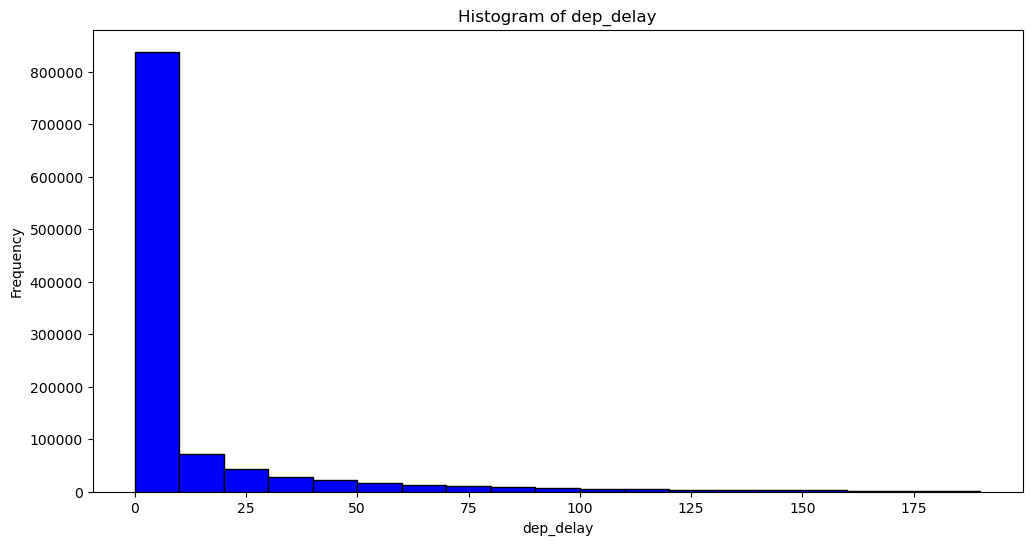

In [87]:
plt.figure(figsize=(12, 6))
plt.hist(flight_df['dep_delay'], bins=range(0, 200, 10), color='blue', edgecolor='black')
plt.title('Histogram of dep_delay')
plt.xlabel('dep_delay')
plt.ylabel('Frequency')
plt.show()

 Tutaj stwórz wykres dla całej kolumny `dep_delay`

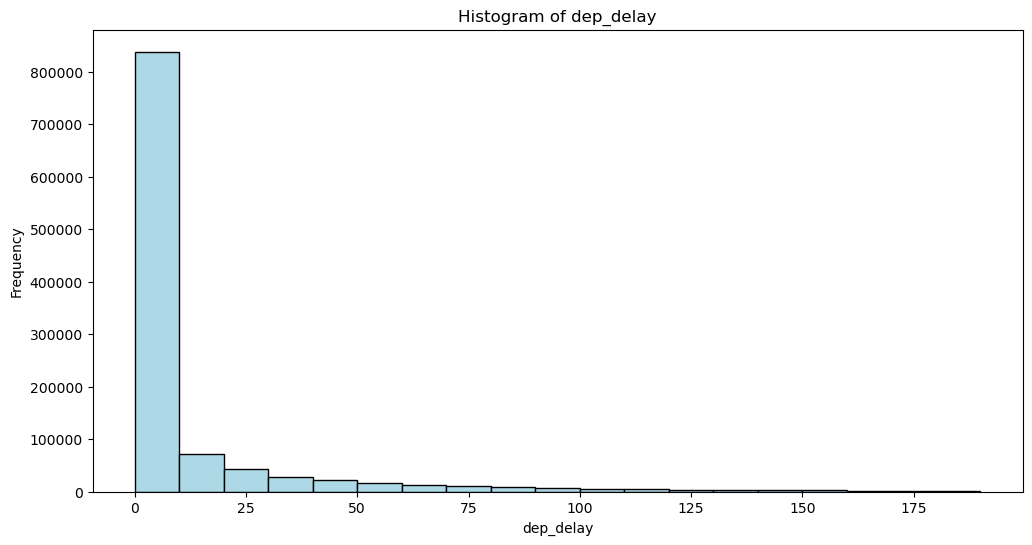

In [93]:
plt.figure(figsize=(12, 6))
plt.hist(flight_df['dep_delay'], bins=range(0, 200, 10), color='lightblue', edgecolor='black')
plt.title('Histogram of dep_delay')
plt.xlabel('dep_delay')
plt.ylabel('Frequency')
plt.show()


 Tutaj stwórz wykres dla `dep_delay` używając warunku `dep_delay > 0`

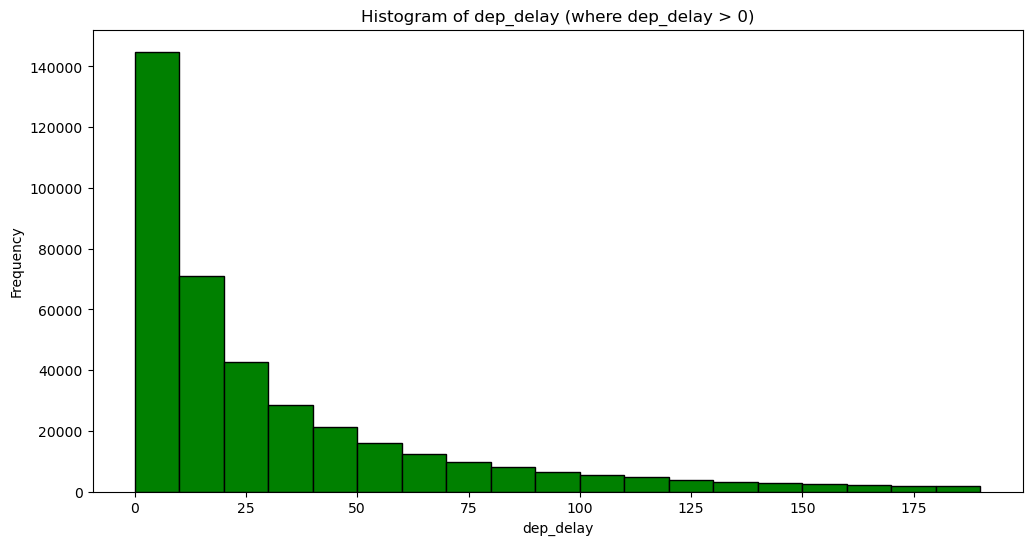

In [91]:
plt.figure(figsize=(12, 6))
plt.hist(flight_df[flight_df['dep_delay'] > 0]['dep_delay'], bins=range(0, 200, 10), color='green', edgecolor='black')
plt.title('Histogram of dep_delay (where dep_delay > 0)')
plt.xlabel('dep_delay')
plt.ylabel('Frequency')
plt.show()

 Tutaj stwórz wykres dla `dep_delay` używając warunków `dep_delay > 0` oraz `dep_delay < percentile 95%`

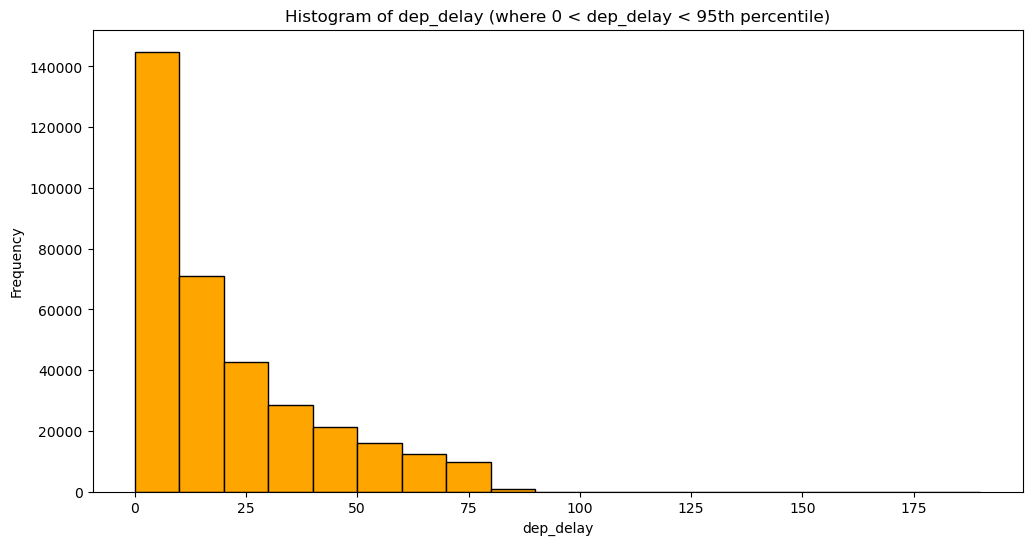

In [92]:
percentile_95 = flight_df['dep_delay'].quantile(0.95)

plt.figure(figsize=(12, 6))
plt.hist(flight_df[(flight_df['dep_delay'] > 0) & (flight_df['dep_delay'] < percentile_95)]['dep_delay'], bins=range(0, 200, 10), color='orange', edgecolor='black')
plt.title('Histogram of dep_delay (where 0 < dep_delay < 95th percentile)')
plt.xlabel('dep_delay')
plt.ylabel('Frequency')
plt.show()

 # Analiza opóźnień
 Zdefiniuj w ramce `flight_df` nową kolumnę - `is_delayed` jako te opóźnienia, które wynosiły więcej niż `(>)` 15 minut.

 Zgodnie z powyższą definicją, wyznacz jaki procent wszystkich lotów był opóźniony. Wynik zapisz do zmiennej `delayed_ratio` z dokładnością do dwóch miejsc po przecinku. Postaraj się, aby wartość tej zmiennej nie była zapisana ręcznie.

 Tutaj stwórz nową kolumnę `is_delayed` oraz odpowiednio ją uzupełnij

In [94]:
flight_df['is_delayed'] = flight_df['dep_delay'] > 15

In [95]:
flight_df['is_delayed']

0          False
1          False
2          False
3          False
4          False
           ...  
1382982    False
1382983     True
1382984    False
1382985     True
1382986    False
Name: is_delayed, Length: 1095742, dtype: bool

 Tutaj zdefiniuj oraz wyznacz wartość dla zmiennej `delayed_ratio`

In [109]:
delayed_ratio = round((flight_df['is_delayed'].sum() / len(flight_df)), 2)

In [110]:
delayed_ratio

0.19

 ### Sprawdzenie
 Uruchom kod poniżej, aby sprawdzić, czy ta część została poprawnie wykonana

In [111]:
delayed_ratio_expected = 0.19
assert delayed_ratio == delayed_ratio_expected, f"Oczekiwanio {delayed_ratio_expected}, otrzymano {delayed_ratio}"

 # Opóźnienia vs. miesiąc kalendarzowy
 Zbadaj, jak zmienia się odsetek opóźnień w zależności od **miesiąca kalendarzowego**. Zadanie wykonaj w dwóch krokach:
 1. stwórz zmienną `flight_delays_by_month_df` używając metody `groupby`,
 1. na podstawie zmiennej `flight_delays_by_month_df`, wygeneruj odpowiedni wykres zgodnie z dobrymi praktykami.

W trakcie pracy nad tym zadaniem możesz posłużyć się następującymi materiałami z `LMS`:
 - `Python - analiza danych -> Dzień 5 - Pandas -> Grupowanie`
 - `groupby`- dokumentacja metody `Pandas`: [klik](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.groupby.html)

 Tutaj pogrupuj dane, a wyniki zapisz do ramki `flight_delays_by_month_df`

In [116]:
flight_delays_by_month_df = flight_df.groupby('month')['is_delayed'].mean().reset_index()


In [117]:
flight_df.columns #sprawdzenie nazw kolumn

Index(['id', 'month', 'day_of_month', 'day_of_week', 'op_unique_carrier',
       'tail_num', 'op_carrier_fl_num', 'origin_airport_id', 'dest_airport_id',
       'crs_dep_time', 'dep_time', 'dep_delay', 'dep_time_blk', 'crs_arr_time',
       'arr_time', 'arr_delay_new', 'arr_time_blk', 'cancelled',
       'crs_elapsed_time', 'actual_elapsed_time', 'distance', 'distance_group',
       'carrier_delay', 'weather_delay', 'nas_delay', 'security_delay',
       'late_aircraft_delay', 'year', 'is_delayed'],
      dtype='object')

 Tutaj narysuj wykres, używając danych z ramki `flight_delays_by_month_df`

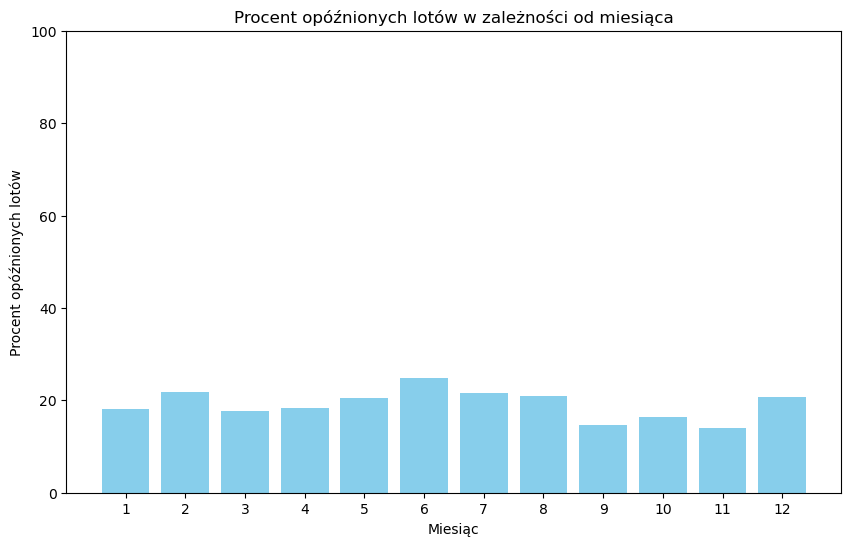

In [119]:
plt.figure(figsize=(10, 6))
plt.bar(flight_delays_by_month_df['month'], flight_delays_by_month_df['is_delayed'] * 100, color='skyblue')

plt.title('Procent opóźnionych lotów w zależności od miesiąca')
plt.xlabel('Miesiąc')
plt.ylabel('Procent opóźnionych lotów')
plt.xticks(flight_delays_by_month_df['month'])
plt.ylim(0, 100)
 

plt.show()


 # Opóźnienia vs. dzień tygodnia cz. 1
 Zbadaj, jak zmienia się odsetek opóźnień w zależności od **dnia tygodnia**. Zadanie wykonaj w dwóch krokach:
 1. stwórz zmienną `flight_delays_by_weekday_df` używając metody `groupby`,
 1. na podstawie zmiennej `flight_delays_by_weekday_df`, wygeneruj odpowiedni wykres zgodnie z dobrymi praktykami.

 Tutaj pogrupuj dane

In [120]:
flight_delays_by_weekday_df = flight_df.groupby('day_of_week')['is_delayed'].mean().reset_index()


In [122]:
flight_delays_by_weekday_df.head()

,day_of_week,is_delayed
0,1,0.201266
1,2,0.174751
2,3,0.182782
3,4,0.212168
4,5,0.203227


 Tutaj narysuj wykres

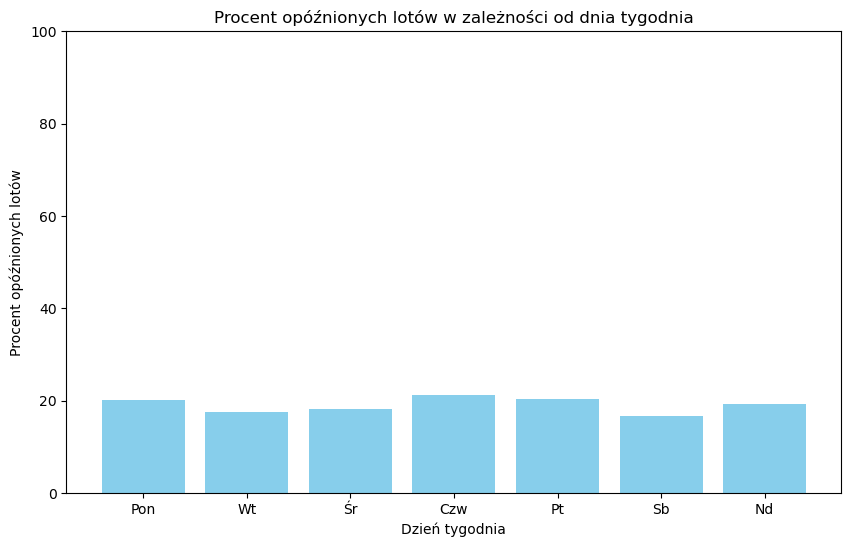

In [123]:
plt.figure(figsize=(10, 6))
plt.bar(flight_delays_by_weekday_df['day_of_week'], flight_delays_by_weekday_df['is_delayed'] * 100, color='skyblue')
plt.title('Procent opóźnionych lotów w zależności od dnia tygodnia')
plt.xlabel('Dzień tygodnia')
plt.ylabel('Procent opóźnionych lotów')
plt.xticks(flight_delays_by_weekday_df['day_of_week'], ['Pon', 'Wt', 'Śr', 'Czw', 'Pt', 'Sb', 'Nd'])
plt.ylim(0, 100)


plt.show()

 # Opóźnienia vs. dzień tygodnia cz. 2
 Dokonaj agregacji kolumny `day_of_week` do nowej kolumny `is_weekend` w `flight_df`. Jako weekend przyjmij wartości 6, 7.
 1. Używając grupowania, wyznacz odsetek opóźnień w zależności od tego, czy lot odbywał się w weekend czy nie. Wyniki zapisz do ramki `flight_delays_by_weekend_df` oraz zaokrąglij do dwóch miejsc po przecinku.
 1. Zaprezentuj graficznie wynik analizy.
 1. Czy Twoim zdaniem odsetek opóźnień jest zależny od tego, czy lot odbywał się w weekend? Uzasadnij.

 Tutaj dodaj nową kolumnę `is_weekend` do `flight_df`

In [124]:
flight_df['is_weekend'] = flight_df['day_of_week'].isin([6, 7])


In [125]:
flight_df['is_weekend'].head()

0    True
1    True
2    True
3    True
4    True
Name: is_weekend, dtype: bool

 Tutaj dokonaj agregacji danych do ramki `flight_delays_by_weekend_df`

In [145]:
flight_delays_by_weekend_df = flight_df.groupby('is_weekend')['is_delayed'].mean().reset_index()
flight_delays_by_weekend_df['is_delayed'] = round(flight_delays_by_weekend_df['is_delayed'], 2)

In [146]:
flight_delays_by_weekend_df

,is_weekend,is_delayed
0,False,0.19
1,True,0.18


 Tutaj narysuj wykres używając danych z ramki `flight_delays_by_weekend_df`

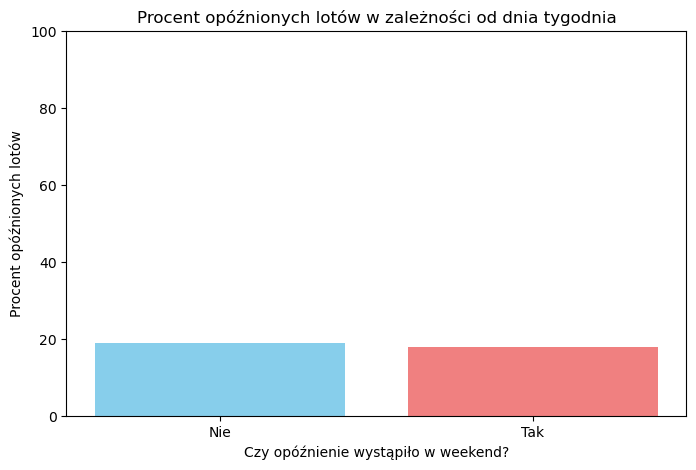

In [147]:
plt.figure(figsize=(8, 5))
plt.bar(flight_delays_by_weekend_df['is_weekend'], flight_delays_by_weekend_df['is_delayed'] * 100, color=['skyblue', 'lightcoral'])
plt.title('Procent opóźnionych lotów w zależności od dnia tygodnia')
plt.xlabel('Czy opóźnienie wystąpiło w weekend?')
plt.ylabel('Procent opóźnionych lotów')
plt.xticks(flight_delays_by_weekend_df['is_weekend'], ['Nie', 'Tak'])
plt.ylim(0, 100)
plt.show()

 ### Sprawdzenie
 Uruchom kod poniżej, aby sprawdzić, czy ta część została poprawnie wykonana

In [148]:
expected_flight_df_by_weekend = {0: 0.19, 1: 0.18}
assert flight_delays_by_weekend_df.to_dict(
) == expected_flight_df_by_weekend, f'Spodziewano się wyników: {expected_flight_df_by_weekend}\n otrzymano  {flight_delays_by_weekend_df}'

AssertionError: Spodziewano się wyników: {0: 0.19, 1: 0.18}
 otrzymano     is_weekend  is_delayed
0       False        0.19
1        True        0.18

 # Opóźnienia vs. odległość lotu
 Przeanalizuj kolumnę `distance`, wykonując poniższe polecenia:  
 1. Podobnie jak dla zmiennej `dep_delay`, wyznacz statystyki opisowe oraz dodatkowo przedstaw percentyle `[0.1, 0.25, 0.5, 0.75, 0.9, 0.95, 0.99]`. Wynik zapisz do zmiennej `flight_distance_analysis_df` oraz zaokrąglij do dwóch miejsc po przecinku.  
 2. Nakreśl wykres punktowy (`scatter`) używając `distance` oraz `dep_delay`. Narysuj wykres dla losowych 10 tysięcy wierszy. Czy na takim wykresie możesz coś zaobserwować?  
 3. Usuń z ramki `flight_df`, te wiersze, dla których `distance` jest powyżej 95% percentyla.  
 4. Używając ramki `flight_df`, dokonaj agregacji zmiennej `distance` co 100 mil do nowej kolumny `distance_agg` oraz wyznacz odsetek opóźnień w każdym koszyku. Wynik zapisz do ramki o nazwie `flight_delays_by_distance_agg_df`.  
 5. Narysuj wykres słupkowy, używając danych zapisanych w `flight_delays_by_distance_agg_df`.  
 6. Czy Twoim zdaniem większy dystans oznacza większe prawdopodobieństwo opóźnienia lotu? Uzasadnij.

 Wskazówka:
 - Przy generowaniu losowych wierszy przyda sie link do dokumentacji metody `sample`: [klik](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.sample.html)
 - Przy generowaniu grup przyda się link do dokumentacji metody `cut`: [klik](https://pandas.pydata.org/docs/reference/api/pandas.cut.html)

 > Dla dużych zbiorów danych kreślenie wszystkich danych mija się z celem ze względu na czytelność. Mimo że zaprezentujemy pewną część zbioru, zakładamy, że danych na wykresie jest na tyle dużo, że stanowią one reprezentacyjną próbkę populacji.

 Tutaj dokonaj agregacji danych do ramki `flight_distance_analysis_df`

In [150]:
flight_distance_analysis_df = flight_df['distance'].describe(percentiles=[0.1, 0.25, 0.5, 0.75, 0.9, 0.95, 0.99]).round(2)

In [151]:
flight_distance_analysis_df.head()

count    1095742.00
mean         758.08
std          600.43
min          100.00
10%          216.00
Name: distance, dtype: float64

 Tutaj narysuj wykres dla 10 000 losowych wierszy z tabeli `flight_df`

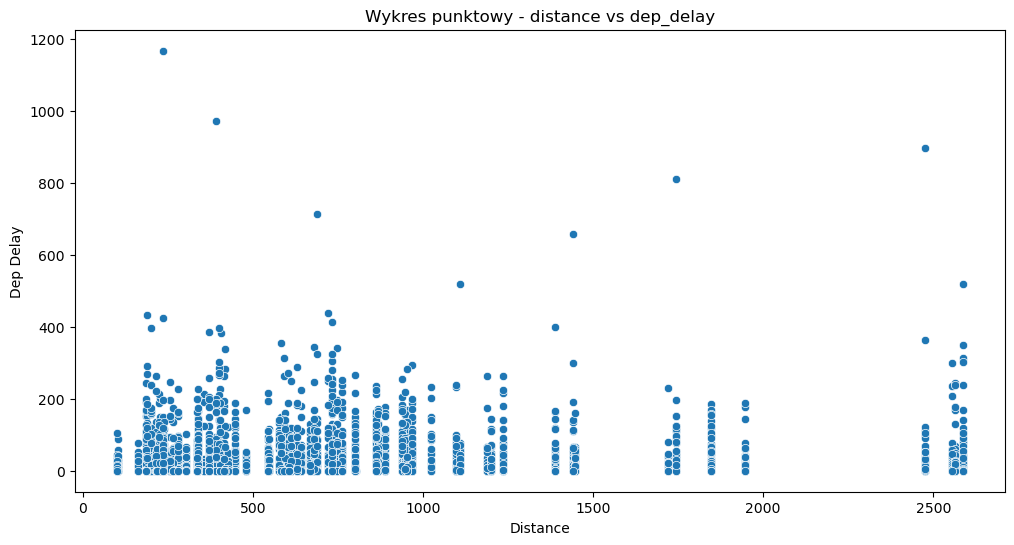

In [152]:
random_sample = flight_df.sample(n=10000)
plt.figure(figsize=(12, 6))
sns.scatterplot(x='distance', y='dep_delay', data=random_sample)
plt.title('Wykres punktowy - distance vs dep_delay')
plt.xlabel('Distance')
plt.ylabel('Dep Delay')
plt.show()

 Tutaj usuń z ramki `flight_df` wiersze, dla których `distance` jest powyżej `95% percentyla` (> 95%)

In [153]:
distance_percentile_95 = flight_df['distance'].quantile(0.95)
flight_df = flight_df[flight_df['distance'] <= distance_percentile_95]

### Sprawdzenie

In [154]:
flight_df_expected_rows_amount = 1057391
flight_df_rows_amount = flight_df.shape[0]

assert flight_df_rows_amount == flight_df_expected_rows_amount, f'Oczekiwano {flight_df_expected_rows_amount} wierszy, otrzymano {flight_df_rows_amount}'

 Tutaj dokonaj agregacji zmiennej `distance` oraz wyznacz odsetek opóźnień

In [174]:
bins = pd.cut(flight_df['distance'], bins=range(0, int(flight_df['distance'].max()) + 100, 100))
flight_delays_by_distance_agg_df = flight_df.groupby(bins)['is_delayed'].mean().reset_index()


flight_df['distance_agg'] = pd.cut(flight_df['distance'], bins=range(0, 3001, 100))


flight_delays_by_distance_agg_df = flight_df.groupby('distance_agg')['is_delayed'].mean().reset_index()
flight_delays_by_distance_agg_df['is_delayed'] = round(flight_delays_by_distance_agg_df['is_delayed'], 2)


 Tutaj narysuj wykres słupkowy używając danych zapisanych w `flight_delays_by_distance_agg_df`

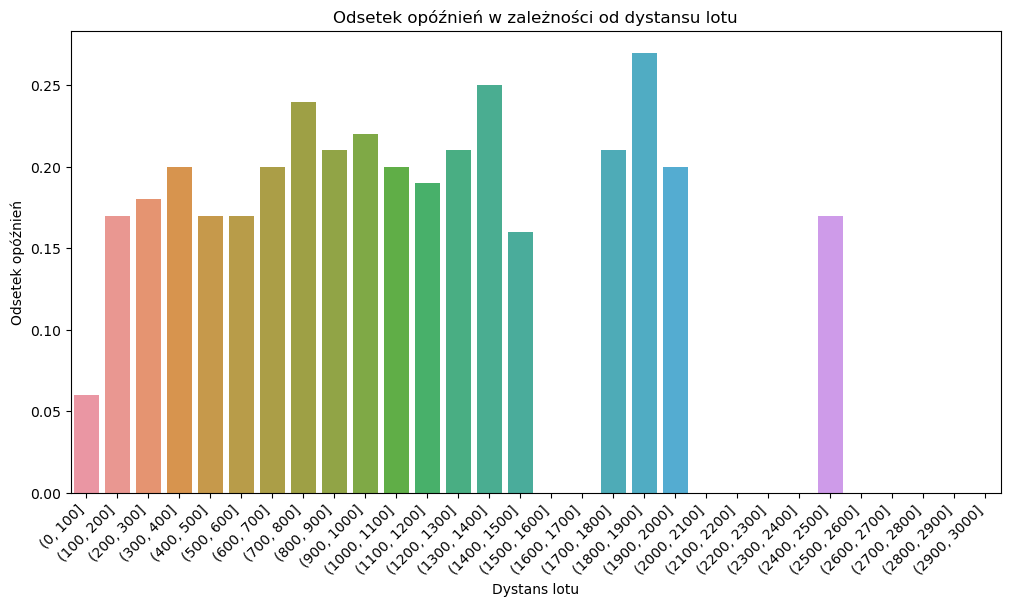

In [175]:
plt.figure(figsize=(12, 6))
sns.barplot(x='distance_agg', y='is_delayed', data=flight_delays_by_distance_agg_df)
plt.title('Odsetek opóźnień w zależności od dystansu lotu')
plt.xlabel('Dystans lotu')
plt.ylabel('Odsetek opóźnień')
plt.xticks(rotation=45, ha='right')  
plt.show()

 ## Sprawdzenie
 Uruchom kod poniżej, aby sprawdzić, czy ta część została poprawnie wykonana

In [177]:
assert 'distance_agg' in flight_df.columns, 'Nie odnaleziono kolumny distance_agg w ramce flight_df'

 # Opóźnienia vs. grupa odległości
 Przeanalizuj kolumnę `distance_group` dostępą w zbiorze danych oraz odpowiedz na poniższe:  
 1. Dla jakich odcinków zostały wyznaczone poszczególne grupy? Wyznacz maksymalną oraz minimalną `distance` wartość w poszczególnych grupach. Wynik zapisz do ramki `flight_distance_by_distance_group`.  
 2. Wyznacz prawdopodobieństwo opóźnienia przy użyciu tych grup. Wynik zapisz do ramki `flight_delays_by_distance_group_df`.  
 3. Używając ramki `flight_delays_by_distance_group_df`, wykreśl odpowiedni wykres wizualizujący dane.  
 4. Na ile zbieżne są wyniki tej analizy z tą wykonaną w poprzednim punkcie?

Wskazówka do punktu pierwszego:
 - Do agregacji danych przyda się metoda `agg`: `Python - analiza danych -> Dzień 5 - Pandas -> Grupowanie`
 - Dokumentacja metody `agg`: [klik](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.agg.html)

Tutaj wyznacz odcinki, dla których zostały wyznaczone poszczególne grupy

In [163]:
flight_distance_by_distance_group = flight_df.groupby('distance_group')['distance'].agg(['min', 'max']).reset_index()


In [164]:
flight_distance_by_distance_group.head()

,distance_group,min,max
0,1,100.0,239.0
1,2,255.0,480.0
2,3,544.0,746.0
3,4,762.0,967.0
4,5,1024.0,1235.0


 Tutaj wyznacz odsetek opóźnień w każdej grupie zapisując wyniki do ramki `flight_delays_by_distance_group_df`

In [165]:
flight_delays_by_distance_group_df = flight_df.groupby('distance_group')['is_delayed'].mean().reset_index()
flight_delays_by_distance_group_df['is_delayed'] = round(flight_delays_by_distance_group_df['is_delayed'], 2)


In [166]:
flight_delays_by_distance_group_df.head()

,distance_group,is_delayed
0,1,0.16
1,2,0.19
2,3,0.20
3,4,0.22
4,5,0.20


 Tutaj narysuj wykres przy użyciu ramki `flight_delays_by_distance_group_df`

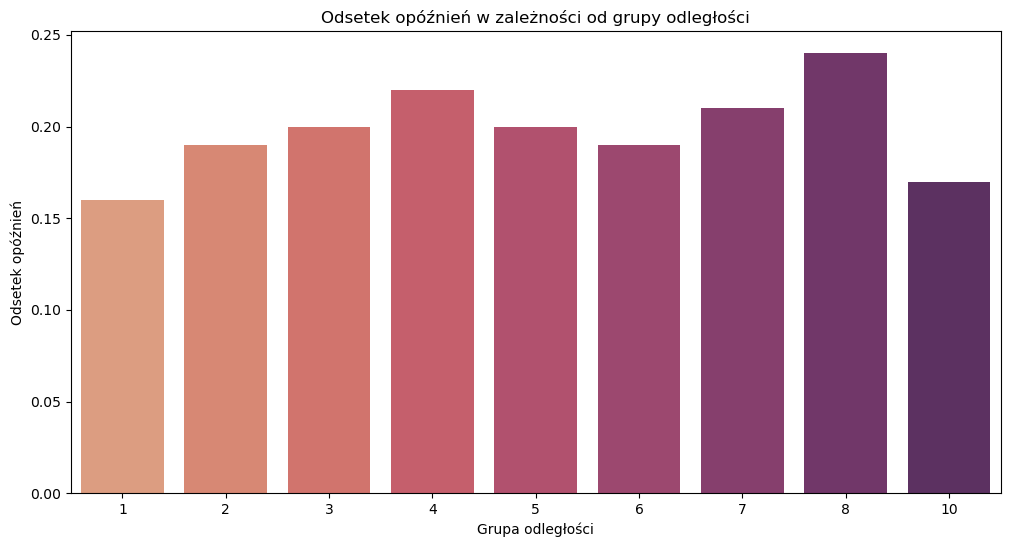

In [170]:
plt.figure(figsize=(12, 6))
sns.barplot(x='distance_group', y='is_delayed', data=flight_delays_by_distance_group_df, palette='flare')
plt.title('Odsetek opóźnień w zależności od grupy odległości')
plt.xlabel('Grupa odległości')
plt.ylabel('Odsetek opóźnień')
plt.xticks(rotation=0)  
plt.show()


 ## Czy większy dystans oznacza większe prawdopodobieństwo opóźnenia lotu?
 Miejsce na Twój komentarz - czy wykresy można porównać? Czy dają takie same wnioski?

> Na podstawie analizy wykresów oraz wyników można wyciągnąć kilka wniosków:
Dystans a opóźnienia: Wykresy opóźnień w zależności od dystansu oraz grupy odległości wskazują, że nie można jednoznacznie stwierdzić, że większy dystans zawsze oznacza większe prawdopodobieństwo opóźnienia lotu. W obu przypadkach występują zarówno opóźnienia, jak i brak opóźnień w różnych grupach dystansu.
Różnice między wykresami: Wykresy opóźnień w zależności od dystansu oraz grupy odległości prezentują różne aspekty analizy. Wykres z grupowaniem odległości w przedziałach (distance_group) pozwala na lepszą identyfikację trendów w poszczególnych grupach, natomiast wykres scatter plot zależności od dystansu i opóźnienia pozwala na zobaczenie rozproszenia danych w sposób bardziej ciągły.
Konieczność analizy dodatkowej: Aby dokładnie ocenić związek między dystansem a opóźnieniem, konieczne byłoby przeprowadzenie bardziej zaawansowanej analizy statystycznej, takiej jak regresja liniowa. Różnice między grupami mogą wynikać z wielu czynników, takich jak warunki atmosferyczne, pora roku, trasy lotów itp.
Zmienność w opóźnieniach: Wykresy pokazują zmienność w opóźnieniach zarówno dla krótkich, jak i długich dystansów. Nie można jednoznacznie stwierdzić, że dla pewnego zakresu dystansu zawsze występują większe opóźnienia.
Podsumowując, analiza wykresów sugeruje, że wpływ dystansu na opóźnienia jest zróżnicowany, a różnice między wykresami wynikają z różnych metod prezentacji danych. Ostateczne wnioski wymagałyby bardziej zaawansowanej analizy statystycznej oraz uwzględnienia dodatkowych czynników wpływających na opóźnienia lotów.

 # Podsumowanie
 W tym notatniku dość dokładnie przeanalizowaliśmy ramkę `fligh_delays` bez wzbogacania jej o dodatkowe dane z innych źródeł, takich jak dane pogodowe.

 Zanim przejdziemy dalej, należy zapisać bieżącą postać ramki (najlepiej lokalnie), która zostanie użyta w kolejnym notatniku.

 > **Wskazówka:**  
 > Aby uniknąć potencjalnych problemów, najlepiej zapisać ramkę w sposób nawiązujący do tego notatnika, np. `flight_df_01`.

 Tutaj zapisz ramkę w najdogodniejszy sposób.

In [179]:
flight_df.to_csv('flight_df_01.csv', index=False)

